In [1]:
from PIL import Image
from numpy import *
from pylab import *

In [2]:
# The data is still available from web archive
# https://web.archive.org/web/20161203110733/http://research.microsoft.com/en-us/um/cambridge/projects/visionimagevideoediting/segmentation/grabcut.htm

In [3]:
from scipy.misc import imresize
import graphcut
graphcut = reload(graphcut)

In [7]:
im = array(Image.open('229036.jpg'))

In [8]:
scale = 0.1
im = imresize(im, scale, interp='bilinear')

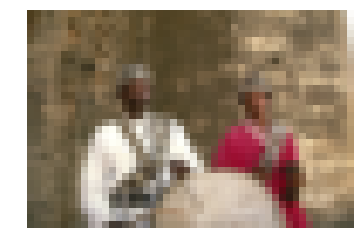

(32, 48, 3)


In [9]:
figure()
imshow(im)
axis('off')
show()
print im.shape

In [76]:
fg = [[16, 24], [32, 32]]
bg = [[0, 0], [48, 8]]

In [77]:
def create_msr_labels(size, fg, bg):
    """ Create labels matrix for training from
    user annotations. """
    
    labels = zeros(size)
    
    for xi in arange(bg[0][0], bg[1][0]):
        for yi in arange(bg[0][1], bg[1][1]):
            labels[yi, xi] = -1

    for xi in arange(fg[0][0], fg[1][0]):
        for yi in arange(fg[0][1], fg[1][1]):
            labels[yi, xi] = 1
    
            
    return labels

In [78]:
labels = create_msr_labels(im.shape[:2], fg, bg)

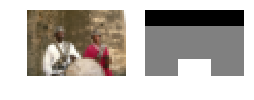

In [79]:
figure()
gray()
subplot(1, 3, 1)
imshow(im)
axis('off')
subplot(1, 3, 2)
imshow(labels)
axis('off')
show()

In [80]:
from pygraph.classes.digraph import digraph
from pygraph.algorithms.minmax import maximum_flow
import bayes


def build_bayes_graph(im, labels, sigma=1e-2, kappa=2, weight=1):
    """ Build a graph from 4-neighborhood of pixels.
    Foregraound and background is determined from
    labels (1 for foreground, -1 for background, 0 othewise)
    and is modeled with naive Bayes classifiers. """

    m, n = im.shape[:2]

    # RGB vector version (one pixel per row)
    vim = im.astype('float')
    vim = vim.reshape((-1, 3))

    # RGB for foreground and background
    foreground = im[labels == 1].reshape((-1, 3))
    background = im[labels == -1].reshape((-1, 3))
    train_data = [foreground, background]

    # train naive Bayes classifier
    bc = bayes.BayesClassifier()
    bc.train(train_data, labels)

    # get probabilities for all pixels
    bc_lables, prob = bc.classify(vim)
    prob_fg = prob[0]
    prob_bg = prob[1]

    # create graph with m*n+2 nodes
    gr = digraph()
    gr.add_nodes(range(m*n+2))

    source = m*n  # second to last is source
    sink = m*n+1  # last node is sink

    # normalize
    pos = m*n/2-100
    for i in range(vim.shape[0]):
        vim[i] = vim[i] / linalg.norm(vim[i])

    # go through all nodes and add edges
    lb = labels.copy()
    lb = lb.flatten()
    for i in range(m*n):
        # add edge from source
        if lb[i]==1:
            gr.add_edge((source, i), wt=weight)
        elif lb[i]==-1:
            gr.add_edge((i, sink), wt=weight)          
        elif (prob_fg[i]>prob_bg[i]):
            gr.add_edge((source, i), wt=(prob_fg[i]/(prob_fg[i] + prob_bg[i])))
        else:
            # add edge to sink
            gr.add_edge((i, sink), wt=(prob_bg[i]/(prob_fg[i] + prob_bg[i])))

        # add edges to neighbors
        if i % n != 0:  # left exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i-1])**2)/sigma)
            gr.add_edge((i, i-1), wt=edge_wt)
        if (i+1) % n != 0:  # right exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i+1])**2)/sigma)
            gr.add_edge((i, i+1), wt=edge_wt)
        if i//n != 0:  # up exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i-n])**2)/sigma)
            gr.add_edge((i, i-n), wt=edge_wt)
        if i//n != m-1:  # down exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i+n])**2)/sigma)
            gr.add_edge((i, i+n), wt=edge_wt)
            
    return gr


In [81]:
print labels

[[-1. -1. -1. ..., -1. -1. -1.]
 [-1. -1. -1. ..., -1. -1. -1.]
 [-1. -1. -1. ..., -1. -1. -1.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [82]:
g = build_bayes_graph(im, labels, sigma=1e-2, kappa=2, weight=100)

In [83]:
res = graphcut.cut_graph(g, im.shape[:2])

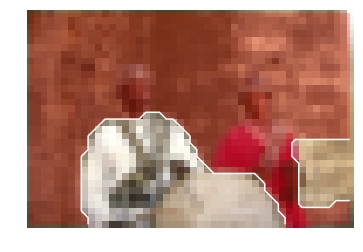

In [84]:
figure()
graphcut.show_labeling(im, res)
show()